<a href="https://colab.research.google.com/github/AnnPike/Portfolio/blob/master/ResNet10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Experiment: constructing small(10 layers) ResNet with different numbers of layers in a block. The first layer is convolutions 4by4 with stride 2, then 8 blocks of convolutions 3by3 with increasing depth(16,16,32,32,32,64,64,64) and then average pooling layer and softmax. ResNet10_35 means that we add identity after the third and the fifth layers of convolulutions 3by3. The architecture resembles classical ResNets. The data is CIFAR10 and the task of a NN is recognition. My goal is to figure out how length of blocks influence the performance of a ResNet.

# Load data and libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            # print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [3]:
import torch
import numpy as np
import time

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

batch_size = 250
valid_size = 0.2
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (1,1,1))])

train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

num_train = len(train_data)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

cuda:0


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


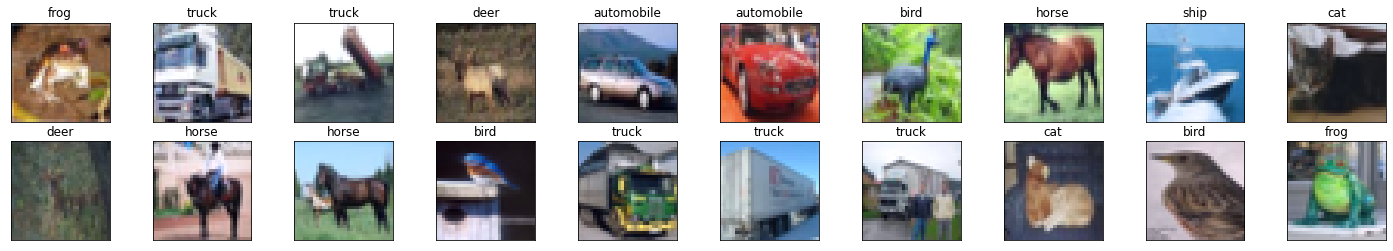

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
  img = img + 0.5
  plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
# obtain one batch of training images
images, labels = iter(torch.utils.data.DataLoader(train_data, batch_size=20)).next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Training function

I used early stopping with patience 3 for training each ResNet and patience 10 for Plain one since it needed some time to start converging.

In [5]:
train_loss_dict = {}
valid_loss_dict = {}
test_accuracy_dict = {}
epochs_dict = {}

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
num_epochs = 100
patience = 3

def train_model(model, batch_size, patience, num_epochs, model_name):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=False)
    
    for epoch in range(1, num_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            data = data.to(device)
            target = target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        with torch.no_grad():
          for data, target in valid_loader:
              data = data.to(device)
              target = target.to(device)
              # forward pass: compute predicted outputs by passing inputs to the model
              output = model(data)
              # calculate the loss
              loss = criterion(output, target)
              # record validation loss
              valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(num_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        # print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))
    model_save_name = model_name+'.pt'
    path = F"/content/gdrive/My Drive/ResNet10_momentum0.9_patience3avpool22/{model_save_name}" 
    torch.save(model.state_dict(), path)
    # add avarage train loss, avarage valid loss and epoch to the dictionaries and plot learning curves
    E = epoch-patience
    print(F"epochs: {E}")
    epochs_dict[model_name] = E
    train_loss_dict[model_name] = avg_train_losses[:-patience]
    valid_loss_dict[model_name] = avg_valid_losses[:-patience]
    plt.plot(range(1,epoch+1),avg_train_losses,'y',label = 'train loss')
    plt.plot(range(1,epoch+1),avg_valid_losses,'b', label = 'valid_loss')
    plt.axvline(x=E, color ='red', linestyle ="--", linewidth = 1)
    plt.legend()
    plt.show()
    return  model

## Testing function

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

def eval_model(model, model_name):
  PREDICT = torch.empty(0).to(device)
  CORRECT = torch.empty(0).to(device)
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  model.eval()
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      loss = criterion(output, target)
      _, pred = torch.max(output,1)
      PREDICT = torch.cat([PREDICT,pred],axis=0)
      CORRECT = torch.cat([CORRECT,target],axis=0)

  cf_matrix = confusion_matrix(CORRECT.cpu(), PREDICT.cpu())
  cf_matrix_pc = (cf_matrix/cf_matrix.sum(axis=0))*100
  sns.heatmap(cf_matrix_pc, annot=True,cmap='Blues', xticklabels=classes)
  plt.title('confusuin matrix for test predictions in percent')
  plt.show()

  print(classification_report(CORRECT.cpu(), PREDICT.cpu(), target_names=classes, digits=4))
  test_accuracy_dict[model_name] = accuracy_score(CORRECT.cpu(), PREDICT.cpu())
  return None

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# ResNet10_8

Early stopping
epochs: 56


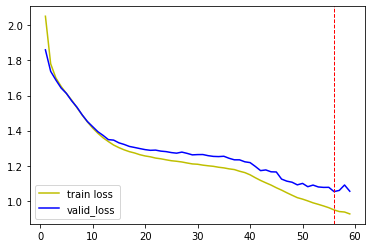

--- 13.143605037530262 minuts ---


In [8]:
model_name = 'ResNet10_8'
class ResNet10_8(nn.Module):
  def __init__(self):
    super(ResNet10_8,self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate', bias=False)
    self.conv2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv3 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv4 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv5 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv6 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv7 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv8 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv9 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_48 = torch.zeros(batch_size,48,16,16, requires_grad=True).to(device)
    x = F.relu(self.conv1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv2(x)) #layer2 
    x = F.relu(self.conv3(x)) #layer3 
    x = F.relu(self.conv4(x)) #layer4 32*16*16
    x = F.relu(self.conv5(x)) #layer5 
    x = F.relu(self.conv6(x)) #layer6 
    x = F.relu(self.conv7(x)) #layer7 64*16*16
    x = F.relu(self.conv8(x)) #layer8
    x = F.relu(self.conv9(x)) #layer9 
    x = F.relu(x + torch.cat([identity,padding_zeros_48],axis=1))
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet10_8()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

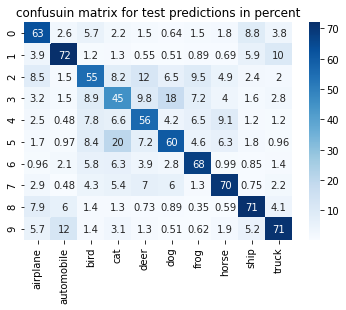

              precision    recall  f1-score   support

    airplane     0.6275    0.7210    0.6710      1000
  automobile     0.7195    0.7440    0.7316      1000
        bird     0.5506    0.4190    0.4759      1000
         cat     0.4518    0.4690    0.4603      1000
        deer     0.5610    0.6160    0.5872      1000
         dog     0.6033    0.4730    0.5303      1000
        frog     0.6752    0.7610    0.7156      1000
       horse     0.6973    0.7050    0.7011      1000
        ship     0.7147    0.7590    0.7362      1000
       truck     0.7105    0.6650    0.6870      1000

    accuracy                         0.6332     10000
   macro avg     0.6312    0.6332    0.6296     10000
weighted avg     0.6312    0.6332    0.6296     10000



In [9]:
eval_model(model, model_name)

# ResNet10_44

Early stopping
epochs: 27


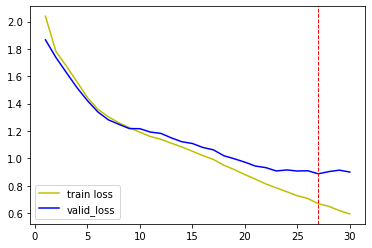

--- 6.228658481438955 minuts ---


In [10]:
model_name = 'ResNet10_44'
class ResNet10_44(nn.Module):
  def __init__(self):
    super(ResNet10_44,self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate', bias=False)
    self.conv2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv3 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv4 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv5 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv6 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv7 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv8 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv9 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_16 = torch.zeros(batch_size,16,16,16).to(device)
    padding_zeros_32 = torch.zeros(batch_size,32,16,16).to(device)
    x = F.relu(self.conv1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv2(x)) #layer2 
    x = F.relu(self.conv3(x)) #layer3 16*16*16
    x = F.relu(self.conv4(x)) #layer4 32*16*16
    x = F.relu(self.conv5(x)) #layer5 32*16*16
    x = F.relu(x + torch.cat([identity,padding_zeros_16],axis=1))
    identity = x.clone()
    x = F.relu(self.conv6(x)) #layer6 32*16*16
    x = F.relu(self.conv7(x)) #layer7 64*16
    x = F.relu(self.conv8(x)) #layer8
    x = F.relu(self.conv9(x)) #layer9 
    x = F.relu(x + torch.cat([identity,padding_zeros_32],axis=1))
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet10_44()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

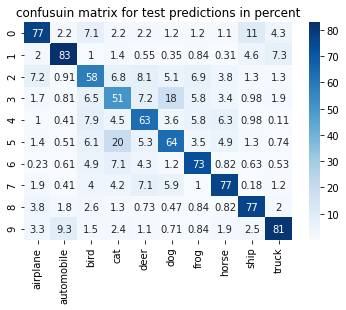

              precision    recall  f1-score   support

    airplane     0.7739    0.6640    0.7147      1000
  automobile     0.8294    0.8170    0.8232      1000
        bird     0.5848    0.5860    0.5854      1000
         cat     0.5064    0.5570    0.5305      1000
        deer     0.6343    0.6920    0.6619      1000
         dog     0.6369    0.5420    0.5856      1000
        frog     0.7330    0.7880    0.7595      1000
       horse     0.7660    0.7430    0.7543      1000
        ship     0.7694    0.8610    0.8126      1000
       truck     0.8072    0.7660    0.7860      1000

    accuracy                         0.7016     10000
   macro avg     0.7041    0.7016    0.7014     10000
weighted avg     0.7041    0.7016    0.7014     10000



In [11]:
eval_model(model, model_name)

# ResNet10_332

Early stopping
epochs: 25


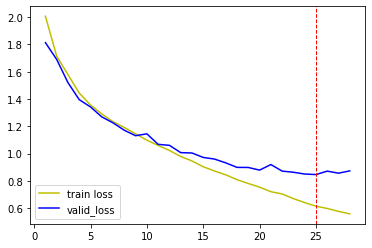

--- 6.071659461657206 minuts ---


In [12]:
model_name = 'ResNet10_332'
class ResNet10_332(nn.Module):
  def __init__(self):
    super(ResNet10_332,self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate', bias=False)
    self.conv2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv3 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv4 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv5 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv6 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv7 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv8 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv9 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_16 = torch.zeros(batch_size,16,16,16).to(device)
    padding_zeros_32 = torch.zeros(batch_size,32,16,16).to(device)
    x = F.relu(self.conv1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv2(x)) #layer2 
    x = F.relu(self.conv3(x)) #layer3 16*16*16
    x = F.relu(self.conv4(x)) #layer4 32*16*16
    x = F.relu(x + torch.cat([identity,padding_zeros_16],axis=1))
    identity = x.clone()
    x = F.relu(self.conv5(x)) #layer5 32*16*16
    x = F.relu(self.conv6(x)) #layer6 32*16*16
    x = F.relu(self.conv7(x)) #layer7 64*16
    x = F.relu(x + torch.cat([identity,padding_zeros_32],axis=1))
    identity = x.clone()
    x = F.relu(self.conv8(x)) #layer8
    x = F.relu(self.conv9(x)) #layer9 
    x = F.relu(x + identity)
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet10_332()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

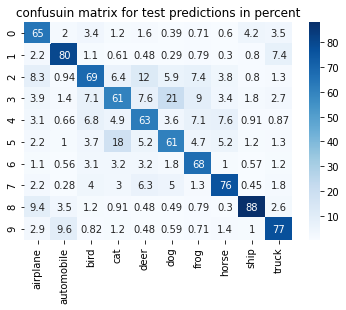

              precision    recall  f1-score   support

    airplane     0.6463    0.8370    0.7294      1000
  automobile     0.8011    0.8540    0.8267      1000
        bird     0.6867    0.5020    0.5800      1000
         cat     0.6067    0.3980    0.4807      1000
        deer     0.6266    0.6510    0.6385      1000
         dog     0.6109    0.6250    0.6179      1000
        frog     0.6751    0.8580    0.7556      1000
       horse     0.7640    0.7640    0.7640      1000
        ship     0.8818    0.7760    0.8255      1000
       truck     0.7729    0.8030    0.7876      1000

    accuracy                         0.7068     10000
   macro avg     0.7072    0.7068    0.7006     10000
weighted avg     0.7072    0.7068    0.7006     10000



In [13]:
eval_model(model, model_name)

# ResNet10_323

Early stopping
epochs: 23


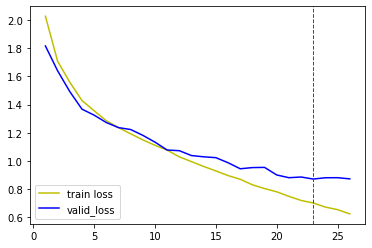

--- 5.82828137477239 minuts ---


In [14]:
model_name = 'ResNet10_323'
class ResNet10_323(nn.Module):
  def __init__(self):
    super(ResNet10_323,self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate', bias=False)
    self.conv2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv3 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv4 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv5 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv6 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv7 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv8 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv9 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_16 = torch.zeros(batch_size,16,16,16).to(device)
    padding_zeros_32 = torch.zeros(batch_size,32,16,16).to(device)
    x = F.relu(self.conv1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv2(x)) #layer2 
    x = F.relu(self.conv3(x)) #layer3 16*16*16
    x = F.relu(self.conv4(x)) #layer4 32*16*16
    x = F.relu(x + torch.cat([identity,padding_zeros_16],axis=1))
    identity = x.clone()
    x = F.relu(self.conv5(x)) #layer5 32*16*16
    x = F.relu(self.conv6(x)) #layer6 32*16*16
    x = F.relu(x + identity)
    identity = x.clone()
    x = F.relu(self.conv7(x)) #layer7 64*16    
    x = F.relu(self.conv8(x)) #layer8
    x = F.relu(self.conv9(x)) #layer9 
    x = F.relu(x + torch.cat([identity,padding_zeros_32],axis=1))
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet10_323()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

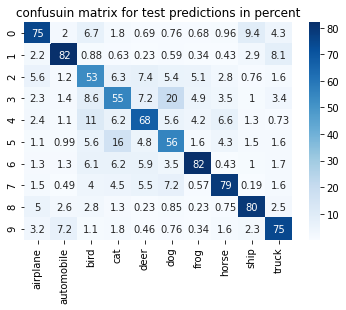

              precision    recall  f1-score   support

    airplane     0.7529    0.7070    0.7292      1000
  automobile     0.8184    0.8290    0.8236      1000
        bird     0.5297    0.6600    0.5877      1000
         cat     0.5530    0.4380    0.4888      1000
        deer     0.6751    0.5900    0.6297      1000
         dog     0.5556    0.6540    0.6008      1000
        frog     0.8207    0.7230    0.7687      1000
       horse     0.7866    0.7370    0.7610      1000
        ship     0.7950    0.8340    0.8141      1000
       truck     0.7454    0.8140    0.7782      1000

    accuracy                         0.6986     10000
   macro avg     0.7032    0.6986    0.6982     10000
weighted avg     0.7032    0.6986    0.6982     10000



In [15]:
eval_model(model, model_name)

# ResNet10_233

Early stopping
epochs: 25


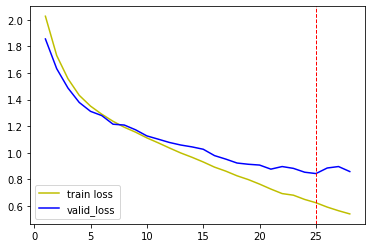

--- 6.211104249954223 minuts ---


In [16]:
model_name = 'ResNet10_233'
class ResNet10_233(nn.Module):
  def __init__(self):
    super(ResNet10_233,self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate', bias=False)
    self.conv2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv3 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv4 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv5 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv6 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv7 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv8 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv9 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_16 = torch.zeros(batch_size,16,16,16).to(device)
    padding_zeros_32 = torch.zeros(batch_size,32,16,16).to(device)
    x = F.relu(self.conv1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv2(x)) #layer2 
    x = F.relu(self.conv3(x)) #layer3 16*16*16
    x = F.relu(x + identity)
    identity = x.clone()
    x = F.relu(self.conv4(x)) #layer4 32*16*1
    x = F.relu(self.conv5(x)) #layer5 32*16*16
    x = F.relu(self.conv6(x)) #layer6 32*16*16
    x = F.relu(x + torch.cat([identity,padding_zeros_16],axis=1))
    identity = x.clone()
    x = F.relu(self.conv7(x)) #layer7 64*16    
    x = F.relu(self.conv8(x)) #layer8
    x = F.relu(self.conv9(x)) #layer9 
    x = F.relu(x + torch.cat([identity,padding_zeros_32],axis=1))
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet10_233()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

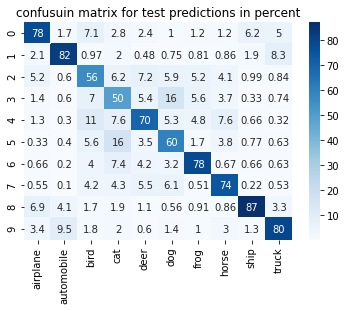

              precision    recall  f1-score   support

    airplane     0.7813    0.7110    0.7445      1000
  automobile     0.8243    0.8210    0.8226      1000
        bird     0.5644    0.6400    0.5998      1000
         cat     0.4966    0.5850    0.5372      1000
        deer     0.6955    0.5780    0.6313      1000
         dog     0.6004    0.6400    0.6196      1000
        frog     0.7830    0.7720    0.7774      1000
       horse     0.7416    0.7720    0.7565      1000
        ship     0.8702    0.7910    0.8287      1000
       truck     0.7977    0.7570    0.7768      1000

    accuracy                         0.7067     10000
   macro avg     0.7155    0.7067    0.7095     10000
weighted avg     0.7155    0.7067    0.7095     10000



In [17]:
eval_model(model, model_name)

# ResNet10_2222

Early stopping
epochs: 18


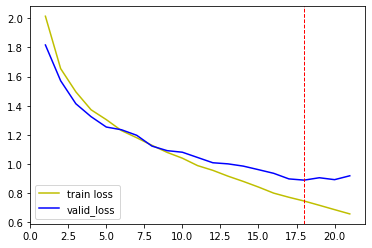

--- 4.395756697654724 minuts ---


In [18]:
model_name = 'ResNet10_2222'
class ResNet10_2222(nn.Module):
  def __init__(self):
    super(ResNet10_2222,self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate', bias=False)
    self.conv2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv3 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv4 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv5 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv6 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv7 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv8 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv9 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_16 = torch.zeros(batch_size,16,16,16).to(device)
    padding_zeros_32 = torch.zeros(batch_size,32,16,16).to(device)
    x = F.relu(self.conv1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv2(x)) #layer2 
    x = F.relu(self.conv3(x)) #layer3 16*16*16
    x = F.relu(x + identity)
    identity = x.clone() 
    x = F.relu(self.conv4(x)) #layer4 32*16*16
    x = F.relu(self.conv5(x)) #layer5 32*16*16
    x = F.relu(x + torch.cat([identity,padding_zeros_16],axis=1))
    identity = x.clone()
    x = F.relu(self.conv6(x)) #layer6 32*16*16
    x = F.relu(self.conv7(x)) #layer7 64*16
    x = F.relu(x + torch.cat([identity,padding_zeros_32],axis=1))
    identity = x.clone()
    x = F.relu(self.conv8(x)) #layer8
    x = F.relu(self.conv9(x)) #layer9 
    x = F.relu(x + identity)
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet10_2222()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

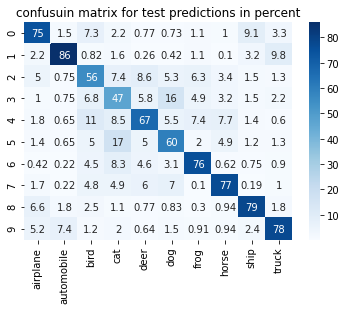

              precision    recall  f1-score   support

    airplane     0.7469    0.7140    0.7301      1000
  automobile     0.8602    0.8000    0.8290      1000
        bird     0.5571    0.6100    0.5823      1000
         cat     0.4704    0.5950    0.5254      1000
        deer     0.6748    0.5250    0.5906      1000
         dog     0.6002    0.5780    0.5889      1000
        frog     0.7594    0.7510    0.7552      1000
       horse     0.7708    0.7400    0.7551      1000
        ship     0.7863    0.8350    0.8099      1000
       truck     0.7784    0.7800    0.7792      1000

    accuracy                         0.6928     10000
   macro avg     0.7004    0.6928    0.6946     10000
weighted avg     0.7004    0.6928    0.6946     10000



In [19]:
eval_model(model, model_name)

# ResNet10_224

Early stopping
epochs: 21


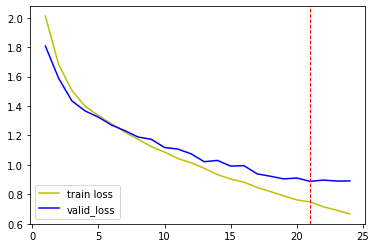

--- 5.1673919280370075 minuts ---


In [20]:
model_name = 'ResNet10_224'
class ResNet10_224(nn.Module):
  def __init__(self):
    super(ResNet10_224,self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate', bias=False)
    self.conv2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv3 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv4 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv5 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv6 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv7 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv8 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv9 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_16 = torch.zeros(batch_size,16,16,16).to(device)
    padding_zeros_32 = torch.zeros(batch_size,32,16,16).to(device)
    x = F.relu(self.conv1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv2(x)) #layer2 
    x = F.relu(self.conv3(x)) #layer3 16*16*16
    x = F.relu(x + identity)
    identity = x.clone() 
    x = F.relu(self.conv4(x)) #layer4 32*16*16
    x = F.relu(self.conv5(x)) #layer5 32*16*16
    x = F.relu(x + torch.cat([identity,padding_zeros_16],axis=1))
    identity = x.clone()
    x = F.relu(self.conv6(x)) #layer6 32*16*16
    x = F.relu(self.conv7(x)) #layer7 64*16
    x = F.relu(self.conv8(x)) #layer8
    x = F.relu(self.conv9(x)) #layer9 
    x = F.relu(x + torch.cat([identity,padding_zeros_32],axis=1))
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores
    
model = ResNet10_224()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

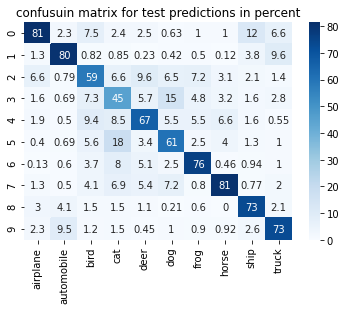

              precision    recall  f1-score   support

    airplane     0.8146    0.6150    0.7009      1000
  automobile     0.8036    0.8100    0.8068      1000
        bird     0.5881    0.5710    0.5794      1000
         cat     0.4529    0.5870    0.5113      1000
        deer     0.6652    0.5900    0.6253      1000
         dog     0.6065    0.5810    0.5935      1000
        frog     0.7610    0.7580    0.7595      1000
       horse     0.8055    0.7000    0.7491      1000
        ship     0.7332    0.8600    0.7915      1000
       truck     0.7295    0.7930    0.7599      1000

    accuracy                         0.6865     10000
   macro avg     0.6960    0.6865    0.6877     10000
weighted avg     0.6960    0.6865    0.6877     10000



In [21]:
eval_model(model, model_name)

# ResNet10_422

Early stopping
epochs: 29


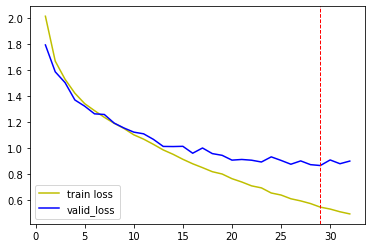

--- 7.079609350363413 minuts ---


In [22]:
model_name = 'ResNet10_422'
class ResNet10_422(nn.Module):
  def __init__(self):
    super(ResNet10_422,self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate', bias=False)
    self.conv2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv3 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv4 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv5 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv6 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv7 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv8 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv9 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_16 = torch.zeros(batch_size,16,16,16).to(device)
    padding_zeros_32 = torch.zeros(batch_size,32,16,16).to(device)
    x = F.relu(self.conv1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv2(x)) #layer2 
    x = F.relu(self.conv3(x)) #layer3 16*16*16
    x = F.relu(self.conv4(x)) #layer4 32*16*16
    x = F.relu(self.conv5(x)) #layer5 32*16*16
    x = F.relu(x + torch.cat([identity,padding_zeros_16],axis=1))
    identity = x.clone()
    x = F.relu(self.conv6(x)) #layer6 32*16*16
    x = F.relu(self.conv7(x)) #layer7 64*16
    x = F.relu(x + torch.cat([identity,padding_zeros_32],axis=1))
    identity = x.clone()
    x = F.relu(self.conv8(x)) #layer8
    x = F.relu(self.conv9(x)) #layer9 
    x = F.relu(x + identity)
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores
    
model = ResNet10_422()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

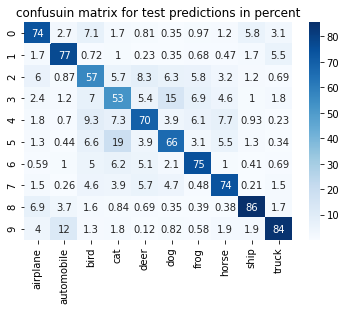

              precision    recall  f1-score   support

    airplane     0.7405    0.7560    0.7481      1000
  automobile     0.7692    0.8830    0.8222      1000
        bird     0.5676    0.6300    0.5972      1000
         cat     0.5256    0.5650    0.5446      1000
        deer     0.6975    0.6040    0.6474      1000
         dog     0.6631    0.5650    0.6102      1000
        frog     0.7505    0.7760    0.7630      1000
       horse     0.7393    0.7800    0.7591      1000
        ship     0.8555    0.8290    0.8421      1000
       truck     0.8437    0.7340    0.7850      1000

    accuracy                         0.7122     10000
   macro avg     0.7152    0.7122    0.7119     10000
weighted avg     0.7152    0.7122    0.7119     10000



In [23]:
eval_model(model, model_name)

# ResNet10_242

Early stopping
epochs: 18


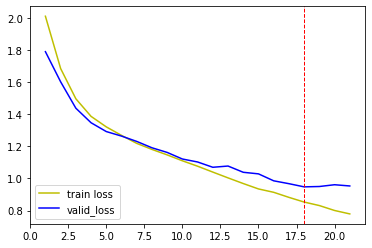

--- 4.822173710664114 minuts ---


In [24]:
model_name = 'ResNet10_242'
class ResNet10_242(nn.Module):
  def __init__(self):
    super(ResNet10_242,self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate', bias=False)
    self.conv2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv3 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv4 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv5 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv6 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv7 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv8 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv9 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_16 = torch.zeros(batch_size,16,16,16).to(device)
    padding_zeros_48 = torch.zeros(batch_size,48,16,16).to(device)
    x = F.relu(self.conv1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv2(x)) #layer2 
    x = F.relu(self.conv3(x)) #layer3 16*16*16
    x = F.relu(x + identity)
    identity = x.clone() 
    x = F.relu(self.conv4(x)) #layer4 32*16*16
    x = F.relu(self.conv5(x)) #layer5 32*16*16
    x = F.relu(self.conv6(x)) #layer6 32*16*16
    x = F.relu(self.conv7(x)) #layer7 64*16
    x = F.relu(x + torch.cat([identity,padding_zeros_48],axis=1))
    identity = x.clone()
    x = F.relu(self.conv8(x)) #layer8
    x = F.relu(self.conv9(x)) #layer9 
    x = F.relu(x + identity)
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores
    
model = ResNet10_242()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

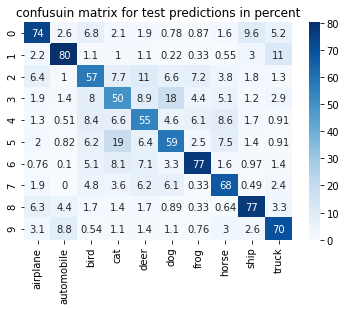

              precision    recall  f1-score   support

    airplane     0.7424    0.6800    0.7098      1000
  automobile     0.8025    0.7800    0.7911      1000
        bird     0.5742    0.5340    0.5534      1000
         cat     0.4965    0.4950    0.4957      1000
        deer     0.5471    0.6210    0.5817      1000
         dog     0.5873    0.5280    0.5561      1000
        frog     0.7726    0.7100    0.7400      1000
       horse     0.6761    0.7430    0.7080      1000
        ship     0.7728    0.7960    0.7842      1000
       truck     0.7044    0.7770    0.7389      1000

    accuracy                         0.6664     10000
   macro avg     0.6676    0.6664    0.6659     10000
weighted avg     0.6676    0.6664    0.6659     10000



In [25]:
eval_model(model, model_name)

# ResNet10_62

Early stopping
epochs: 29


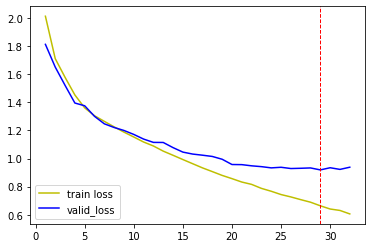

--- 7.207793736457825 minuts ---


In [26]:
model_name = 'ResNet10_62'
class ResNet10_62(nn.Module):
  def __init__(self):
    super(ResNet10_62,self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate', bias=False)
    self.conv2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv3 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv4 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv5 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv6 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv7 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv8 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv9 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_48 = torch.zeros(batch_size,48,16,16).to(device)
    x = F.relu(self.conv1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv2(x)) #layer2 
    x = F.relu(self.conv3(x)) #layer3 16*16*16 
    x = F.relu(self.conv4(x)) #layer4 32*16*16
    x = F.relu(self.conv5(x)) #layer5 32*16*16
    x = F.relu(self.conv6(x)) #layer6 32*16*16
    x = F.relu(self.conv7(x)) #layer7 64*16
    x = F.relu(x + torch.cat([identity,padding_zeros_48],axis=1))
    identity = x.clone()
    x = F.relu(self.conv8(x)) #layer8
    x = F.relu(self.conv9(x)) #layer9 
    x = F.relu(x + identity)
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores
    
model = ResNet10_62()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

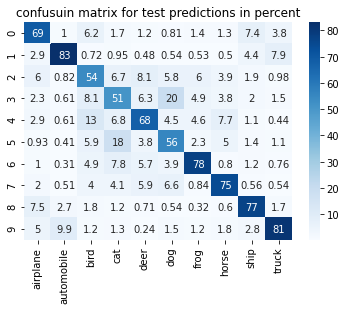

              precision    recall  f1-score   support

    airplane     0.6940    0.7460    0.7190      1000
  automobile     0.8311    0.8120    0.8214      1000
        bird     0.5438    0.6080    0.5741      1000
         cat     0.5137    0.4860    0.4995      1000
        deer     0.6758    0.5690    0.6178      1000
         dog     0.5592    0.6190    0.5876      1000
        frog     0.7793    0.7380    0.7581      1000
       horse     0.7463    0.7470    0.7466      1000
        ship     0.7725    0.8250    0.7979      1000
       truck     0.8118    0.7460    0.7775      1000

    accuracy                         0.6896     10000
   macro avg     0.6927    0.6896    0.6900     10000
weighted avg     0.6927    0.6896    0.6900     10000



In [27]:
eval_model(model, model_name)

# ResNet10_26

Early stopping
epochs: 31


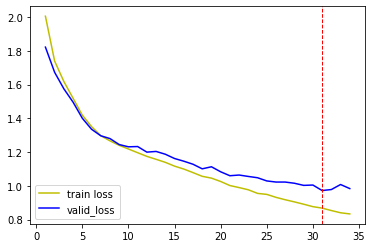

--- 7.66467174688975 minuts ---


In [28]:
model_name = 'ResNet10_26'
class ResNet10_26(nn.Module):
  def __init__(self):
    super(ResNet10_26,self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate', bias=False)
    self.conv2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv3 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv4 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv5 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv6 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv7 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv8 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv9 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_48 = torch.zeros(batch_size,48,16,16).to(device)
    x = F.relu(self.conv1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv2(x)) #layer2 
    x = F.relu(self.conv3(x)) #layer3 16*16*16
    x = F.relu(x + identity)
    identity = x.clone() 
    x = F.relu(self.conv4(x)) #layer4 32*16*16
    x = F.relu(self.conv5(x)) #layer5 32*16*16
    x = F.relu(self.conv6(x)) #layer6 32*16*16
    x = F.relu(self.conv7(x)) #layer7 64*16
    x = F.relu(self.conv8(x)) #layer8
    x = F.relu(self.conv9(x)) #layer9 
    x = F.relu(x + torch.cat([identity,padding_zeros_48],axis=1))
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores
    
model = ResNet10_26()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

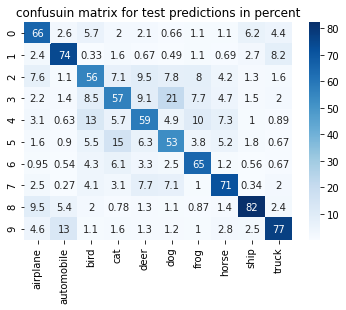

              precision    recall  f1-score   support

    airplane     0.6554    0.7590    0.7034      1000
  automobile     0.7433    0.8280    0.7833      1000
        bird     0.5569    0.5040    0.5291      1000
         cat     0.5668    0.3650    0.4440      1000
        deer     0.5863    0.5230    0.5529      1000
         dog     0.5288    0.6430    0.5803      1000
        frog     0.6506    0.8230    0.7267      1000
       horse     0.7134    0.7220    0.7177      1000
        ship     0.8221    0.7350    0.7761      1000
       truck     0.7711    0.6940    0.7305      1000

    accuracy                         0.6596     10000
   macro avg     0.6595    0.6596    0.6544     10000
weighted avg     0.6595    0.6596    0.6544     10000



In [29]:
eval_model(model, model_name)

# ResNet10_53

Early stopping
epochs: 28


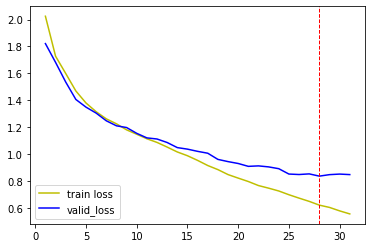

--- 6.97760048309962 minuts ---


In [30]:
model_name = 'ResNet10_53'
class ResNet10_53(nn.Module):
  def __init__(self):
    super(ResNet10_53,self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate', bias=False)
    self.conv2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv3 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv4 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv5 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv6 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv7 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv8 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv9 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_16 = torch.zeros(batch_size,16,16,16).to(device)
    padding_zeros_32 = torch.zeros(batch_size,32,16,16).to(device)
    x = F.relu(self.conv1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv2(x)) #layer2 
    x = F.relu(self.conv3(x)) #layer3 
    x = F.relu(self.conv4(x)) #layer4 32*16*16
    x = F.relu(self.conv5(x)) #layer5 
    x = F.relu(self.conv6(x)) #layer6 
    x = F.relu(x + torch.cat([identity,padding_zeros_16],axis=1))
    identity = x.clone()
    x = F.relu(self.conv7(x)) #layer7 64*16    
    x = F.relu(self.conv8(x)) #layer8
    x = F.relu(self.conv9(x)) #layer9 
    x = F.relu(x + torch.cat([identity,padding_zeros_32],axis=1))
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet10_53()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

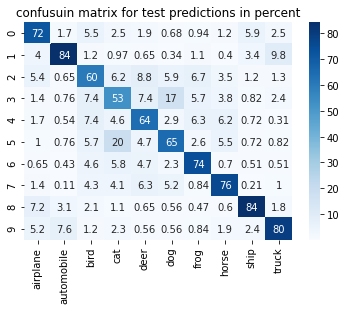

              precision    recall  f1-score   support

    airplane     0.7203    0.7750    0.7466      1000
  automobile     0.8432    0.7800    0.8104      1000
        bird     0.6049    0.5940    0.5994      1000
         cat     0.5295    0.5480    0.5386      1000
        deer     0.6434    0.6910    0.6663      1000
         dog     0.6501    0.5760    0.6108      1000
        frog     0.7446    0.7960    0.7695      1000
       horse     0.7627    0.7650    0.7639      1000
        ship     0.8419    0.8200    0.8308      1000
       truck     0.7951    0.7760    0.7854      1000

    accuracy                         0.7121     10000
   macro avg     0.7136    0.7121    0.7122     10000
weighted avg     0.7136    0.7121    0.7122     10000



In [31]:
eval_model(model, model_name)

# ResNet10_35

Early stopping
epochs: 31


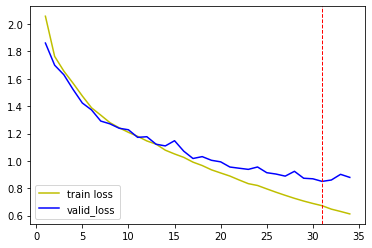

--- 7.668724846839905 minuts ---


In [32]:
model_name = 'ResNet10_35'
class ResNet10_35(nn.Module):
  def __init__(self):
    super(ResNet10_35,self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate', bias=False)
    self.conv2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv3 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv4 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv5 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv6 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv7 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv8 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv9 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_16 = torch.zeros(batch_size,16,16,16).to(device)
    padding_zeros_32 = torch.zeros(batch_size,32,16,16).to(device)
    x = F.relu(self.conv1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv2(x)) #layer2 
    x = F.relu(self.conv3(x)) #layer3 16*16*16
    x = F.relu(self.conv4(x)) #layer4 32*16*16
    x = F.relu(x + torch.cat([identity,padding_zeros_16],axis=1))
    identity = x.clone()
    x = F.relu(self.conv5(x)) #layer5 32*16*16
    x = F.relu(self.conv6(x)) #layer6 32*16*16
    x = F.relu(self.conv7(x)) #layer7 64*16    
    x = F.relu(self.conv8(x)) #layer8
    x = F.relu(self.conv9(x)) #layer9 
    x = F.relu(x + torch.cat([identity,padding_zeros_32],axis=1))
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet10_35()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

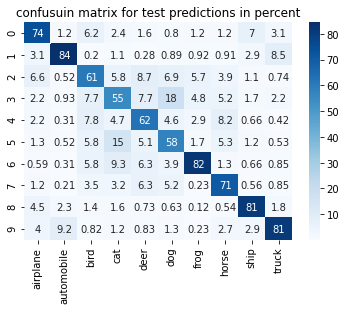

              precision    recall  f1-score   support

    airplane     0.7431    0.7550    0.7490      1000
  automobile     0.8446    0.8150    0.8295      1000
        bird     0.6082    0.5960    0.6020      1000
         cat     0.5541    0.4710    0.5092      1000
        deer     0.6239    0.6800    0.6507      1000
         dog     0.5782    0.6470    0.6107      1000
        frog     0.8224    0.7130    0.7638      1000
       horse     0.7083    0.7820    0.7433      1000
        ship     0.8130    0.8650    0.8382      1000
       truck     0.8106    0.7660    0.7877      1000

    accuracy                         0.7090     10000
   macro avg     0.7106    0.7090    0.7084     10000
weighted avg     0.7106    0.7090    0.7084     10000



In [33]:
eval_model(model, model_name)

# PlainNet10

Early stopping
epochs: 45


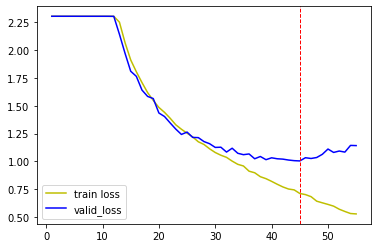

--- 10.245468668142955 minuts ---


In [49]:
model_name = 'Plain10'
class Plain10(nn.Module):
  def __init__(self):
    super(Plain10,self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate', bias=False)
    self.conv2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv3 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv4 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv5 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv6 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv7 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv8 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.conv9 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate', bias=False)
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    x = F.relu(self.conv1(x)) #layer1 16*16*16
    x = F.relu(self.conv2(x)) #layer2 
    x = F.relu(self.conv3(x)) #layer3 
    x = F.relu(self.conv4(x)) #layer4 32*16*16
    x = F.relu(self.conv5(x)) #layer5 
    x = F.relu(self.conv6(x)) #layer6 
    x = F.relu(self.conv7(x)) #layer7 64*16*16
    x = F.relu(self.conv8(x)) #layer8
    x = F.relu(self.conv9(x)) #layer9 
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores

model = Plain10()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
patience = 10
model = train_model(model, batch_size, patience, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

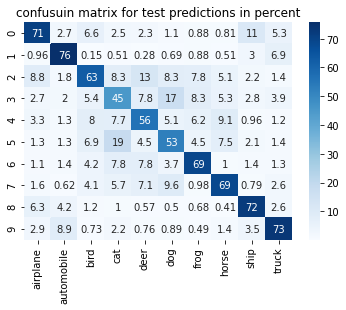

              precision    recall  f1-score   support

    airplane     0.7109    0.6640    0.6867      1000
  automobile     0.7566    0.8550    0.8028      1000
        bird     0.6272    0.4290    0.5095      1000
         cat     0.4549    0.4490    0.4519      1000
        deer     0.5630    0.5940    0.5781      1000
         dog     0.5287    0.5340    0.5313      1000
        frog     0.6924    0.7090    0.7006      1000
       horse     0.6884    0.6760    0.6821      1000
        ship     0.7214    0.8260    0.7702      1000
       truck     0.7331    0.7690    0.7506      1000

    accuracy                         0.6505     10000
   macro avg     0.6477    0.6505    0.6464     10000
weighted avg     0.6477    0.6505    0.6464     10000



In [50]:
eval_model(model, model_name)

# Models comparison

In [51]:
import pickle
path = "/content/gdrive/My Drive/ResNet10_momentum0.9_patience3avpool22/" 

pickle.dump(train_loss_dict, open(path+"train_loss_dict_10", 'wb'))
pickle.dump(valid_loss_dict, open(path+"valid_loss_dict_10", 'wb'))
pickle.dump(test_accuracy_dict, open(path+"test_accuracy_dict_10", 'wb'))
pickle.dump(epochs_dict, open(path+"epochs_dict_10", 'wb'))

train_loss_dict = pickle.load(open(path+"train_loss_dict_10", 'rb'))
valid_loss_dict = pickle.load(open(path+"valid_loss_dict_10", 'rb'))
test_accuracy_dict = pickle.load(open(path+"test_accuracy_dict_10", 'rb'))
epochs_dict = pickle.load(open(path+"epochs_dict_10", 'rb'))

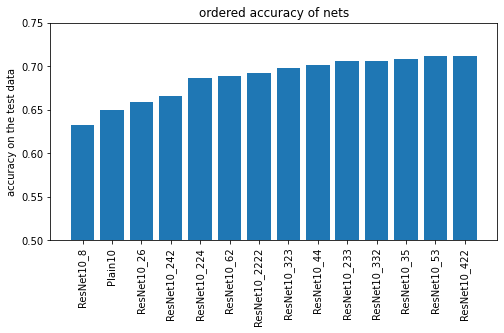

In [52]:
import matplotlib.pyplot as plt
ordered_dict_accuracy = {k: v for k, v in sorted(test_accuracy_dict.items(), key=lambda item: item[1])}
ordered_nets = list(ordered_dict_accuracy.keys())
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(ordered_nets, height=ordered_dict_accuracy.values())
ax.set_ylim([0.5,0.75])
plt.xticks(rotation=90)
plt.ylabel('accuracy on the test data')
plt.title('ordered accuracy of nets')
plt.show()

In [53]:
nets = train_loss_dict.keys()
print(list(nets))

['ResNet10_8', 'ResNet10_44', 'ResNet10_332', 'ResNet10_323', 'ResNet10_233', 'ResNet10_2222', 'ResNet10_224', 'ResNet10_422', 'ResNet10_242', 'ResNet10_62', 'ResNet10_26', 'ResNet10_53', 'ResNet10_35', 'Plain10']


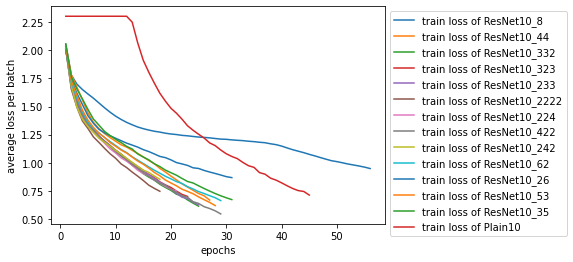

In [54]:

for n in nets:
  plt.plot(range(1,epochs_dict[n]+1),train_loss_dict[n], label = 'train loss of '+n)
  
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel('epochs')
plt.ylabel('average loss per batch')
plt.show()

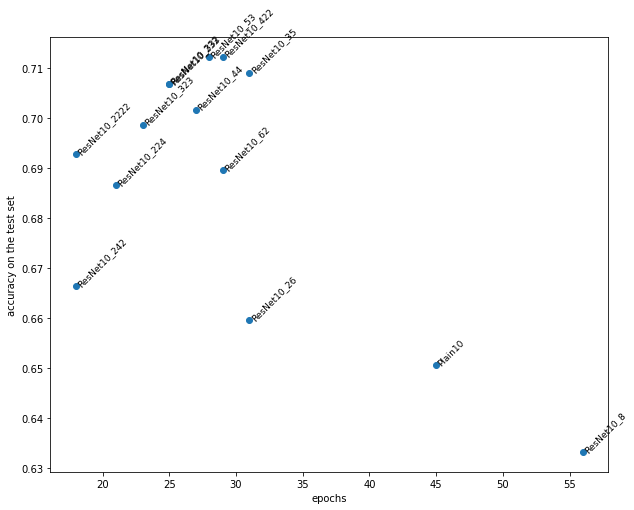

In [58]:
epochs_list = [i for i in epochs_dict.values()]
test_accuracy_list = [i for i in test_accuracy_dict.values()]
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(epochs_list, test_accuracy_list)
for i, txt in enumerate(nets):
    ax.annotate(txt, (epochs_list[i],test_accuracy_list[i]),rotation=45,size=9)
plt.xlabel('epochs')
plt.ylabel('accuracy on the test set')
plt.show()

The plain model needs some time to start converging and performance is worse than of all the ResNets except the one with a single block of size 8. The best performing model is ResNet10_422. The fastest AND very vell performing models are ResNet10_332 and ResNet10_233.

Architecture without average poling was tried, performance on test data for each NN was from 1% to 6% less than with average pooling.